# Portfolio Optimization

## Import Required Libraries 

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

## Define Tickers and Time Range 

Define the list 

In [2]:
tickers = ['SPY','BND','GLD','QQQ','VTI']

# SPY: Most Popular S&P500 Index
# BND: Bond Index
# GLD: Largest Comodity Based ETF
# QQQ: Biggeste NASDAQ ETF
# VTI: Entire World Stock Marcket

Set the end date to today

In [3]:
end_date = datetime.today()

Set the start date to N years ago

In [4]:
# N is the number of years ago
N = 5

start_date = end_date - timedelta(days = N*365)

## Download Adjusted Close Prices

Store the adjusted close prices in an empty DataFrame.
More accurate, because they include dividends and stock splits

In [5]:
adj_close_df = pd.DataFrame()

Download the close prices for each ticker

In [6]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, group_by='column', auto_adjust=True)
    adj_close_df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Display the DataFrame

In [7]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2020-08-05  309.233643  77.197258  191.350006  263.201691  156.947311
2020-08-06  311.300690  77.318222  193.889999  266.687805  157.709549
2020-08-07  311.524170  77.231834  190.809998  263.609558  157.839676
2020-08-10  312.455292  77.145447  190.149994  262.483154  158.276581
2020-08-11  309.876160  76.877556  179.940002  257.511353  157.003036
...                ...        ...         ...         ...         ...
2025-07-29  635.260010  73.137398  306.250000  567.260010  312.609985
2025-07-30  634.460022  72.948036  300.959991  568.020020  312.250000
2025-07-31  632.080017  72.957993  302.959991  565.010010  310.890015
2025-08-01  621.719971  73.589996  309.109985  553.880005  305.739990
2025-08-04  628.880005  73.514999  310.510986  561.710022  309.348999

[1255 rows x 5 columns]


# Calculate Lognormal Returns

In [8]:
# One day's prcie divided by the previous day's price

log_returns = np.log(adj_close_df / adj_close_df.shift(1))
log_returns = log_returns.dropna()

## Calculate Covariance Matrix

Calculate the covariance matrix using annualized log returns 

It is how we measure the total risk of the portfolio

In [9]:
cov_matrix = log_returns.cov()*252 #number of trading days per year
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.030627  0.001909  0.003625  0.038337  0.031103
BND  0.001909  0.003596  0.003152  0.002738  0.002000
GLD  0.003625  0.003152  0.023805  0.004883  0.003779
QQQ  0.038337  0.002738  0.004883  0.054431  0.039008
VTI  0.031103  0.002000  0.003779  0.039008  0.031916


## Define Portfolio Performance Metrics 

Calculate the portfolio standard deviation

In [10]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

Calculate the expected return (assuming they will be like the average of past returns, which might not acctually be the best assumption)

In [11]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

Calculate the Sharpe Ratio

In [12]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

## Portfolio Optimization

Although it might not be the most accurate, in Finance Text Books, it's very commun to assume a Risk Free Rate of 2% 

In [13]:
risk_free_rate = 0.02

Define the function to minimize (Negative Sharp Ratio)

In [14]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

Set the constraints (conditions that must be met during the optimization problem) and bounds (limits placed on each variable):

In [ ]:
# All the weights must sum to 1
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1} 

# Lower Bound as 0: we cannot go short on any of the assets
# Higher Bound as 0.5: more than half of our portfolio cannot be allocated to the same asset 
bounds = [(0, 0.5) for _ in range(len(tickers))]

Set the initial weights

In [16]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


Optimize the weights to maximize Sharpe Ratio

SLSQP (Sequential Least Squares Quadratic Programming) is a nummerical optimization technique useful for solving nonlinear optimization problems with constraints

In [ ]:
optimized_results = minimize(
    neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate),
    method='SLSQP', constraints=constraints, bounds= bounds)

In [18]:
optimal_weights = optimized_results.x

## Analyze the Optimal Portfolio

Display analytics of the optimal portfolio 

In [19]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SPY: 0.5000
BND: 0.0000
GLD: 0.4507
QQQ: 0.0000
VTI: 0.0493

Expected Annual Return: 0.1219
Expected Volatility: 0.1261
Sharpe Ratio: 0.8079


## Display the final portfolio in a plot

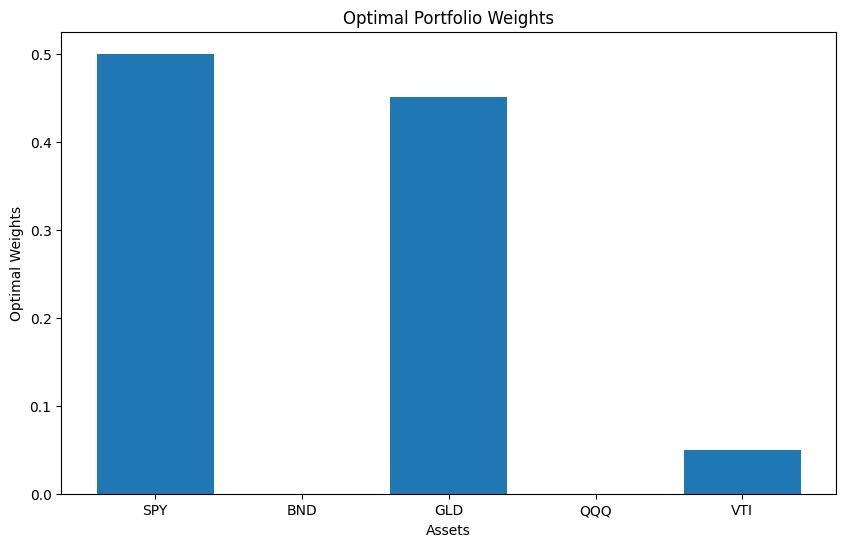

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()